In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt

In [2]:
# Load data
df_combined = pd.read_excel("combined_countries.xlsx")

In [3]:
# Parse list of countries from string

df_combined["countries_from_text"] = df_combined["countries_from_text"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)


In [4]:
# Extract context sentences for each country
def extract_country_context(text, country_list):
    if pd.isna(text) or not country_list:
        return ""
    sentences = re.split(r'(?<=[.!?])\s+', text)
    context_sentences = [s for s in sentences if any(country in s for country in country_list)]
    return " | ".join(context_sentences)

df_combined["country_context_sentences"] = df_combined.apply(
    lambda row: extract_country_context(row["extracted_text"], row["countries_from_text"]), axis=1
)

In [5]:
# Explode countries to get one row per (company, country)
expanded_df = df_combined.explode("countries_from_text").rename(columns={"countries_from_text": "country"})

In [6]:
# Inferred relationship logic
def final_context_weight(rel):
    rel = rel.lower()
    if "sourced from" in rel or "manufacturing" in rel or "production" in rel:
        return 1.0
    elif "exporter" in rel:
        return 0.8
    elif "operates in" in rel:
        return 0.6
    elif "importer" in rel:
        return 0.1
    else:
        return 0.1


In [7]:
def infer_relationship(context, country):
    if pd.isna(context):
        return "mentioned"
    sentence = context.lower()
    if any(kw in sentence for kw in ["export", "exported", "exports"]):
        return f"{country} is an exporter"
    elif any(kw in sentence for kw in ["import", "imported", "imports"]):
        return f"{country} is an importer"
    elif any(kw in sentence for kw in ["source", "sourced", "sourcing"]):
        return f"Goods are sourced from {country}"
    elif any(kw in sentence for kw in ["manufacture", "manufacturing", "produced", "production"]):
        return f"Production or manufacturing in {country}"
    elif any(kw in sentence for kw in ["operate", "operation", "presence in", "office in", "facility in"]):
        return f"Company operates in {country}"
    else:
        return f"{country} is mentioned"

In [8]:
expanded_df["inferred_relationship"] = expanded_df.apply(
    lambda row: infer_relationship(row["country_context_sentences"], row["country"]), axis=1
)
expanded_df["context_score_raw"] = expanded_df["inferred_relationship"].apply(final_context_weight)


In [9]:
# Goods extraction
goods_list = {
      "cotton", "minerals", "gold", "tin", "tantalum", "tobacco", "cobalt", "electronics", "garments",
    "textiles", "apparel", "sugar", "tea", "coffee", "coal", "oil", "gas", "rubber", "palm oil",
    "timber", "fishing", "meat", "fabrics", "shoes", "footwear", "leather", "furniture", "toys"
}

In [10]:
def extract_goods(text):
    if pd.isna(text):
        return ""
    found_goods = [word for word in goods_list if word in text.lower()]
    return "; ".join(sorted(set(found_goods)))

expanded_df["goods_custom"] = expanded_df["country_context_sentences"].apply(extract_goods)

In [11]:
# Frequency score
frequency_df = expanded_df.groupby("country")["company_name"].nunique().reset_index()
frequency_df.columns = ["country", "mention_count"]
frequency_df["frequency_score"] = frequency_df["mention_count"] / frequency_df["mention_count"].max()

In [12]:
# Context score
context_score_df = expanded_df.groupby("country")["context_score_raw"].mean().reset_index()
context_score_df.columns = ["country", "context_score"]


In [13]:
# Goods score
goods_score_df = expanded_df[expanded_df["goods_custom"] != ""].copy()
goods_score_df["goods_count"] = goods_score_df["goods_custom"].apply(lambda x: len(x.split("; ")))
goods_sum_df = goods_score_df.groupby("country")["goods_count"].sum().reset_index()
goods_sum_df["goods_score"] = goods_sum_df["goods_count"] / goods_sum_df["goods_count"].max()
goods_sum_df = goods_sum_df[["country", "goods_score"]]


In [14]:
# Diversity score
expanded_df["company_size"] = expanded_df["company_size"].fillna("")
expanded_df["sectors"] = expanded_df["sectors"].fillna("")
diversity_df = expanded_df.groupby("country").agg({
    "sectors": lambda x: len(set(sum([s.split(";") for s in x if s], []))),
    "company_size": lambda x: len(set(x))
}).reset_index()
diversity_df.columns = ["country", "sector_diversity", "size_diversity"]
diversity_df["diversity_raw"] = diversity_df["sector_diversity"] + diversity_df["size_diversity"]
diversity_df["diversity_score"] = diversity_df["diversity_raw"] / diversity_df["diversity_raw"].max()
diversity_df = diversity_df[["country", "diversity_score"]]

In [15]:
# Sector score
sector_weights = {
    "Agriculture": 1.0,
    "Food & Staples Retailing": 1.0,
    "Textiles": 0.9,
    "Apparel": 0.9,
    "Retailing": 0.9,
    "Materials": 0.8,
    "Mining": 0.8,
    "Consumer Durables": 0.7,
    "Household Products": 0.7,
    "Manufacturing": 0.5,
    "Capital Goods": 0.5,
    "Energy": 0.4,
    "Utilities": 0.4,
    "Technology": 0.3,
    "Information Technology": 0.3,
    "Health Care": 0.2,
    "Pharmaceuticals": 0.2,
    "Financials": 0.1,
    "Insurance": 0.1,
    "Real Estate": 0.1,
    "Telecommunication Services": 0.1,
    "Commercial & Professional Services": 0.1
}


In [16]:
expanded_df["sector_list"] = expanded_df["sectors"].apply(lambda x: [s.strip() for s in x.split(";") if s.strip()])
sector_exploded = expanded_df.explode("sector_list")
sector_exploded["sector_score"] = sector_exploded["sector_list"].map(sector_weights).fillna(0.1)
sector_score_df = sector_exploded.groupby("country")["sector_score"].mean().reset_index()
sector_score_df.columns = ["country", "sector_score"]

In [17]:
# Merge all scores
risk_df = frequency_df.merge(context_score_df, on="country", how="outer")
risk_df = risk_df.merge(goods_sum_df, on="country", how="outer")
risk_df = risk_df.merge(diversity_df, on="country", how="outer")
risk_df = risk_df.merge(sector_score_df, on="country", how="outer")
risk_df = risk_df.fillna(0)

In [18]:
# Final weights
weights = {
    "frequency_score": 0.1,
    "context_score": 0.35,
    "goods_score": 0.25,
    "diversity_score": 0.1,
    "sector_score": 0.2
}

In [19]:
# Final risk score
risk_df["final_risk_score"] = (
    risk_df["frequency_score"] * weights["frequency_score"] +
    risk_df["context_score"] * weights["context_score"] +
    risk_df["goods_score"] * weights["goods_score"] +
    risk_df["diversity_score"] * weights["diversity_score"] +
    risk_df["sector_score"] * weights["sector_score"]
)

In [20]:
# Sort
risk_df = risk_df.sort_values("final_risk_score", ascending=False).reset_index(drop=True)

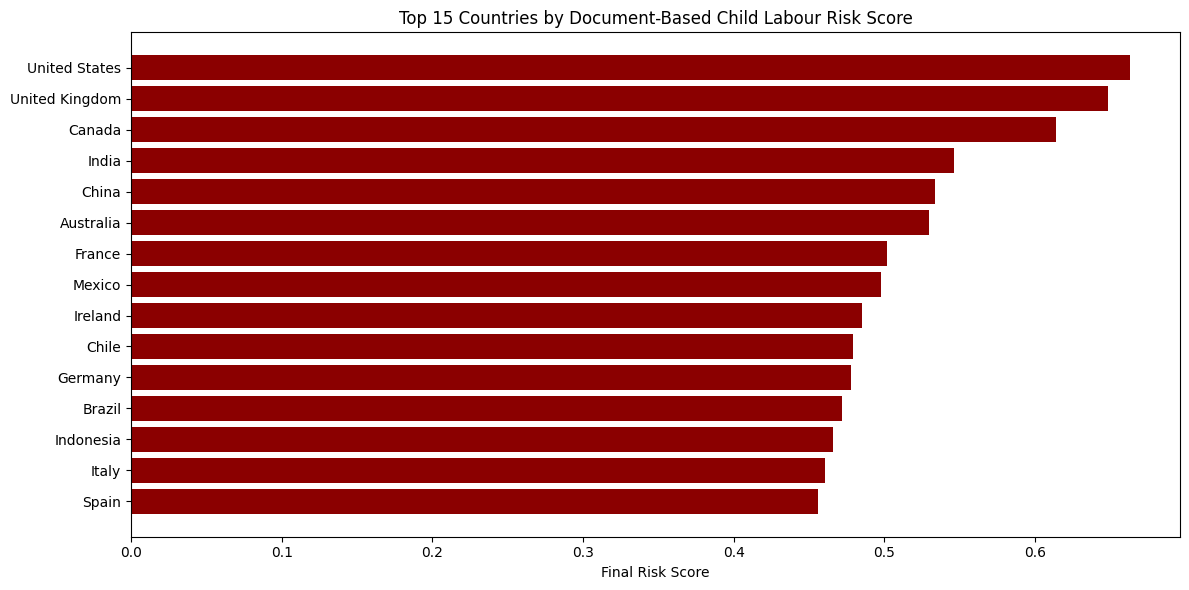

In [21]:
# Select the top 15 countries based on final risk score
top_risk_df = risk_df.head(15)

# Create a horizontal bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_risk_df["country"], top_risk_df["final_risk_score"], color='darkred')
plt.xlabel("Final Risk Score")
plt.title("Top 15 Countries by Document-Based Child Labour Risk Score")
plt.gca().invert_yaxis()  # Highest risk at the top
plt.tight_layout()
plt.show()

In [22]:
# Export the final country risk index to a CSV file
risk_df.to_csv("final_country_risk_index.csv", index=False)

In [23]:
risk_df.head(10)

,country,mention_count,frequency_score,context_score,goods_score,diversity_score,sector_score,final_risk_score
0,United States,87,0.820755,0.533333,1.000000,1.000000,0.221154,0.662973
1,United Kingdom,106,1.000000,0.487736,0.920635,1.000000,0.238400,0.648546
2,Canada,64,0.603774,0.633846,0.769841,0.933333,0.228571,0.613731
3,India,49,0.462264,0.600000,0.619048,0.933333,0.209524,0.546226
4,China,54,0.509434,0.566667,0.579365,0.933333,0.230769,0.533605
5,Australia,48,0.452830,0.602083,0.531746,0.933333,0.237288,0.529740
6,France,37,0.349057,0.608108,0.468254,0.933333,0.218182,0.501777
7,Mexico,33,0.311321,0.669697,0.404762,0.866667,0.222500,0.497883
8,Ireland,34,0.320755,0.658824,0.365079,0.933333,0.190244,0.485316
9,Chile,22,0.207547,0.736364,0.325397,0.733333,0.229630,0.479090
